In [2]:
from pathlib import Path
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
from config import _EXAMPLEDATA_DIR

from mcit.vil import get_vil_from_azran

#viewable plots
import matplotlib.pyplot as plt
%matplotlib inline 
from klaus_krause_cmap import get_zdr_cmap, get_obj_cmap



In [4]:
#############################################################################
#need  to read in the radar name information to set the center point on the array
def read_nexrad_radarinfo( radar_name ):
    file = open(Path(_EXAMPLEDATA_DIR, "nexrad_level2", "radarinfo_ext.dat"), "r")
    Lines = file.readlines()
    file.close()

    #
    for line in Lines:
        #Strips the newline character
        line = line.strip()
        res = line.split() #on white space I think
        if (res[0] == radar_name):
            #print(res)
            return res


In [5]:
#ingest VIL data from file (this gives us an euqal starting point)
import xarray as xr
# Replace 'your_file.nc' with the path to your NetCDF file
file_path = Path(_EXAMPLEDATA_DIR, "test", 'VIL_00.00_20190324-234337.netcdf.gz')

# Open the NetCDF file
ds = xr.open_dataset(file_path)
# Check if 'VIL' variable exists
if 'VIL' in ds:
    vil_data = ds['VIL']
    print("VIL Data:")
    print(vil_data)
else:
    print("Variable 'VIL' not found in the dataset.")

VIL Data:
<xarray.DataArray 'VIL' (Lat: 600, Lon: 600)> Size: 1MB
[360000 values with dtype=float32]
Dimensions without coordinates: Lat, Lon


In [6]:
#
#Determine data geographical coordinates
#
radarname = ds.attrs['radarName-value']
#radarinfo = read_nexrad_radarinfo(radarname)
lat0 = 32.573
lon0 = -97.30315

longridspacing = ds.LonGridSpacing
latgridspacing = ds.LatGridSpacing

lon_nw = ds.Longitude
lat_nw = ds.Latitude

old_lon = ds.Lon.copy()
old_lat = ds.Lat.copy()

ds = ds.assign_coords(Lon=(lon_nw + longridspacing * old_lon),
                      Lat=(lat_nw - latgridspacing * old_lat))

x_m, y_m = pyart.core.geographic_to_cartesian_aeqd(ds.Lon, ds.Lat, lon0, lat0)
x_km = x_m/1000.0
y_km = y_m/1000.0
ds = ds = ds.assign_coords(x=("Lon", x_km), y=("Lat", y_km))


In [7]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:  (Lat: 600, Lon: 600)
Coordinates:
  * Lon      (Lon) float64 5kB -100.6 -100.5 -100.5 ... -93.98 -93.97 -93.96
  * Lat      (Lat) float64 5kB 35.27 35.26 35.25 35.24 ... 29.9 29.89 29.88
    x        (Lon) float64 5kB -295.2 -294.3 -293.3 -292.3 ... 320.7 321.7 322.8
    y        (Lat) float64 5kB 304.6 303.6 302.6 301.5 ... -292.2 -293.2 -294.2
Data variables:
    VIL      (Lat, Lon) float32 1MB ...
Attributes: (12/54)
    MissingData:                   -99900.0
    Elevation:                     0.0
    ElevationUnits:                Degrees
    RangeToFirstGate:              2125.0
    RangeToFirstGateUnits:         Meters
    RangeFolded:                   -99901.0
    ...                            ...
    Vertical_Trans_Power-unit:     kW
    radarName-value:               KFWS
    radarName-unit:                dimensionless
    vcp-value:                     212.000000
    vcp-unit:                      dimensionless
    attributes:                    Atmos C Cal_Z Cal_Zdr FilenameDateTime Fre...

In [8]:
from mcit.mcit_objects import mcit_objects
from mcit.mcit_objects import mcit_trim

In [9]:
mcit_raw = mcit_objects(ds['VIL'], 2.0, 1.25)
mcit_final = mcit_trim(mcit_raw, ds['VIL'])
#I've turned of the mcit_trim in the main mcit_objects code. 

F:\BOKU\CIWRO\hotspots\mcit\mcit_objects.py:90: RuntimeWarning: invalid value encountered in log10
  linear_vil = 10.0 * np.log10(vil_xy.data)


In [10]:
#ingest and plot the MCIT data generated in c++
# Replace 'your_file.nc' with the path to your NetCDF file
file_path = Path(_EXAMPLEDATA_DIR, "test", "StormID_00.00_20190324-234337.netcdf")

# Open the NetCDF file
ds_c = xr.open_dataset(file_path)
print("")
print(" Max:  %f ", ds_c.max())
print(" Min:  %f", ds_c.min())
#ds_c.info()
#ds_c = ds_c.rename_dims({'Lat': 'y', 'Lon': 'x'})



 Max:  %f  <xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    KMeans   float32 4B 79.0
 Min:  %f <xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    KMeans   float32 4B -9.99e+04


In [11]:
#
radarname = ds_c.attrs['radarName-value']

longridspacing = ds_c.LonGridSpacing
latgridspacing = ds_c.LatGridSpacing

lon_nw = ds_c.Longitude
lat_nw = ds_c.Latitude

ds_c = ds_c.assign_coords(Lon=(lon_nw + longridspacing * ds_c.Lon),
                      Lat=(lat_nw - latgridspacing * ds_c.Lat))

x, y = pyart.core.geographic_to_cartesian_aeqd(ds_c.Lon, ds_c.Lat, lon0, lat0)
x_km = x/1000.0
y_km = y/1000.0
ds_c = ds_c.assign_coords(x=("x", x_km), y=("y", y_km))

#not sure why we need this, but we do.
#I didn't do a good job of naming my variable here.....
#ds_c = ds_c.rename_vars({'KMeans':'StormID'})
ds_c['StormID'] = ds_c['KMeans'].swap_dims({'Lat': 'y', 'Lon': 'x'})
#ds_c = da.to_dataset()

In [12]:
#ds_c = ds_c.fillna(-1)
mcit_c = ds_c

In [13]:
#mcit_c.info()

mcit_c['MCIT_objects'] = mcit_c['StormID']
print(mcit_c)

print(" Max:  %f ", mcit_c.max())
print(" Min:  %f", mcit_c.min())


<xarray.Dataset> Size: 4MB
Dimensions:       (Lat: 600, Lon: 600, x: 600, y: 600)
Coordinates:
  * Lon           (Lon) float64 5kB -100.6 -100.5 -100.5 ... -93.97 -93.95
  * Lat           (Lat) float64 5kB 35.27 35.26 35.25 35.24 ... 29.9 29.89 29.88
  * x             (x) float64 5kB -295.2 -294.2 -293.2 ... 320.7 321.8 322.9
  * y             (y) float64 5kB 304.6 303.6 302.6 ... -292.2 -293.2 -294.1
Data variables:
    KMeans        (Lat, Lon) float32 1MB -9.99e+04 -9.99e+04 ... -9.99e+04
    StormID       (y, x) float32 1MB -9.99e+04 -9.99e+04 ... -9.99e+04 -9.99e+04
    MCIT_objects  (y, x) float32 1MB -9.99e+04 -9.99e+04 ... -9.99e+04 -9.99e+04
Attributes: (12/50)
    MissingData:                   -99900.0
    RangeFolded:                   -99901.0
    Latitude:                      35.27109909057617
    Longitude:                     -100.55400085449219
    Height:                        0.0
    Time:                          1553471017
    ...                            ...
  

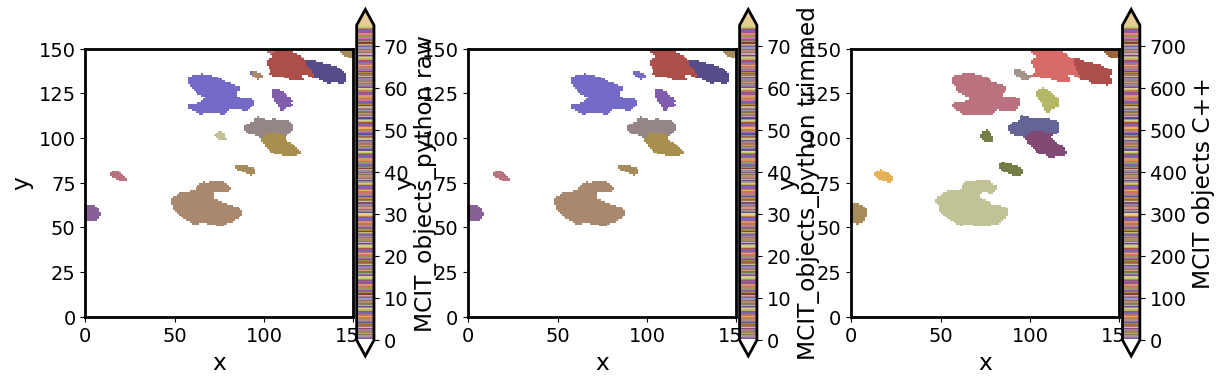

In [14]:
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

axislabels = ["X (km)", "Y (km)"]
axisXlabels = ["X (km)", ""]
axisYlabels = ["", "Y (km)"]
axisnonelabels = ["", ""]
xlim = [0, 150]
ylim = [0, 150]
xdiff = xlim[1] - xlim[0]
axps = xdiff * 0.075
ayps = xdiff * 0.025

fig = plt.figure(figsize=(14, 5))
object_cmap = get_obj_cmap()


ax1 = fig.add_subplot(131)
ax1.set_aspect('equal')
ax1.set_ylabel('')
ax1.set_title("")
mcit_raw.plot(ax=ax1, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap=object_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'MCIT_objects_python raw', 'shrink':0.9}
                                           )


ax2 = fig.add_subplot(132)
ax2.set_aspect('equal')
ax2.set_ylabel('')
ax2.set_title("")

mcit_final.plot(ax=ax2, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap=object_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'MCIT_objects_python trimmed', 'shrink':0.9}
                                           )



ax3 = fig.add_subplot(133)
ax3.set_aspect('equal')
ax3.set_ylabel('')
ax3.set_title("")
mcit_c['MCIT_objects'].plot(ax=ax3, x='x', y='y',
                                         vmin=0.0, vmax=750.0,
                                           xlim=xlim, ylim=ylim,
                                           cmap=object_cmap,
                                             add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'MCIT objects C++', 'shrink':0.9}
                                           )



plt.show()